In [20]:
import os
import itertools
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

In [57]:
param_grid = {
    'history_size': [10, 50, 100],
    'n_users': [20000, 50000, 70000],
    'title_size': [10, 50, 100],
    'learning_rate': [0.0001, 0.001, 0.01],
    'dropout':  [0.1, 0.3, 0.5]
}

combinations = list(itertools.product(
    # param_grid['history_size'],
    # param_grid['n_users'],
    # param_grid['title_size'],
    param_grid['learning_rate'],
    param_grid['dropout']
))

In [58]:
results = []

for learning_rate, dropout in combinations:
    # MODEL_NAME = f"LSTUR_h{history_size}_u{n_users}_t{title_size}"
    MODEL_NAME = f"LSTUR_l{learning_rate}_d{dropout}"
    RESULTS_DIR = f"downloads/evaluations/{MODEL_NAME}"
    results_file = os.path.join(RESULTS_DIR, 'evaluation_results.txt')
    
    if os.path.exists(results_file):
        with open(results_file, 'r') as file:
            # Read the results from the file
            eval_results = {}
            for line in file:
                key, value = line.strip().split(': ')
                eval_results[key] = float(value)
            
            # Add the hyperparameters to the results
            eval_results['history_size'] = history_size
            eval_results['n_users'] = n_users
            eval_results['title_size'] = title_size
            eval_results['learning_rate'] = learning_rate
            eval_results['dropout'] = dropout
            
            
            # Append to the results list
            results.append(eval_results)
    else:
        print(f"Results file not found for combination: history_size={history_size}, n_users={n_users}, title_size={title_size}")

In [59]:
df = pd.DataFrame(results)
df

,auc,mrr,ndcg@5,ndcg@10,history_size,n_users,title_size,learning_rate,dropout
0,0.534073,0.336484,0.371266,0.448404,100,70000,100,0.0001,0.1
1,0.531536,0.330405,0.364859,0.446696,100,70000,100,0.0001,0.3
2,0.526923,0.325328,0.360998,0.439484,100,70000,100,0.0001,0.5
3,0.543749,0.335093,0.374928,0.452880,100,70000,100,0.0010,0.1
4,0.540918,0.338172,0.374232,0.451736,100,70000,100,0.0010,0.3
5,0.533092,0.332853,0.367767,0.448355,100,70000,100,0.0010,0.5
6,0.513135,0.316676,0.349903,0.434997,100,70000,100,0.0100,0.1
7,0.529766,0.324557,0.363198,0.444207,100,70000,100,0.0100,0.3
8,0.556247,0.345059,0.384770,0.461603,100,70000,100,0.0100,0.5


/tmp/ipykernel_5128/369575023.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heatmap_data[['auc', 'mrr', 'ndcg@5', 'ndcg@10']] = scaler.fit_transform(heatmap_data[['auc', 'mrr', 'ndcg@5', 'ndcg@10']])


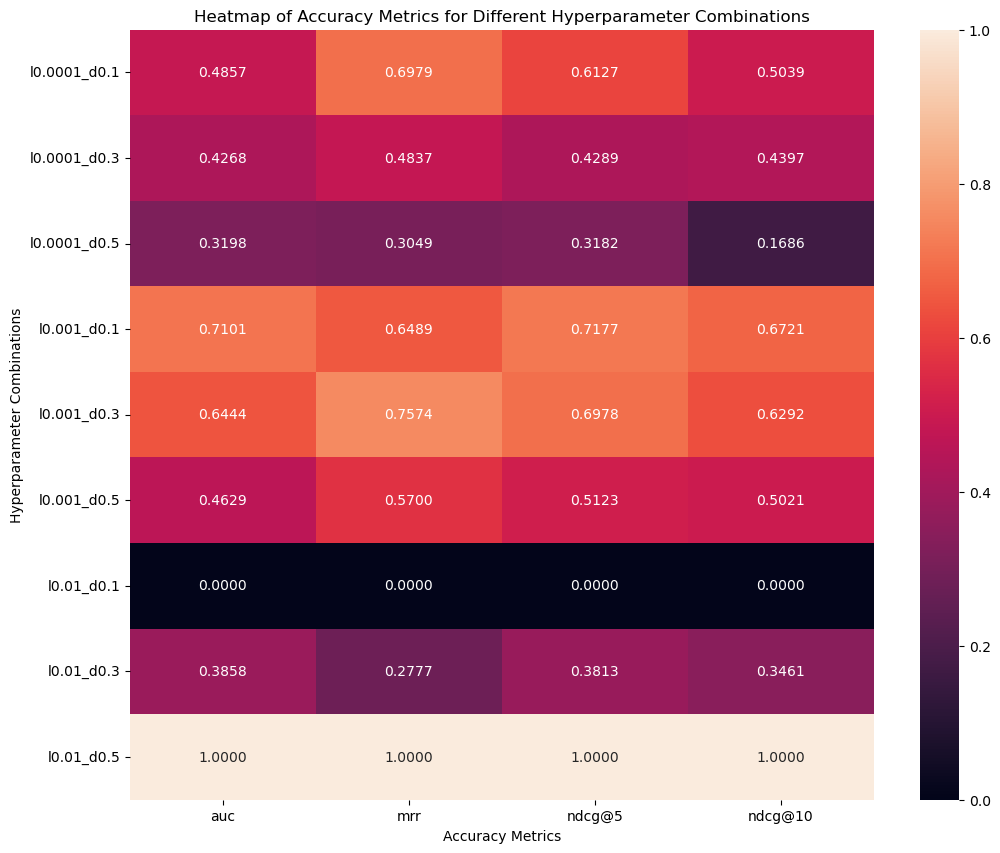

In [60]:
# df['combination'] = df.apply(lambda row: f"h{row['history_size']}_u{row['n_users']}_t{row['title_size']}", axis=1)
df['combination'] = df.apply(lambda row: f"l{row['learning_rate']}_d{row['dropout']}", axis=1)

# Select only the relevant columns for the heatmap
heatmap_data = df[['combination', 'auc', 'mrr', 'ndcg@5', 'ndcg@10']]

# Set the combination column as the index
heatmap_data.set_index('combination', inplace=True)

# Normalize each metric individually
scaler = MinMaxScaler()
heatmap_data[['auc', 'mrr', 'ndcg@5', 'ndcg@10']] = scaler.fit_transform(heatmap_data[['auc', 'mrr', 'ndcg@5', 'ndcg@10']])

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(heatmap_data, annot=True, fmt=".4f", cbar=True)
plt.title('Heatmap of Accuracy Metrics for Different Hyperparameter Combinations')
plt.ylabel('Hyperparameter Combinations')
plt.xlabel('Accuracy Metrics')
plt.show()

/tmp/ipykernel_5128/2276536009.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_results = df.groupby('dropout').mean().reset_index()
/tmp/ipykernel_5128/2276536009.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heatmap_data[['auc', 'mrr', 'ndcg@5', 'ndcg@10']] = scaler.fit_transform(heatmap_data[['auc', 'mrr', 'ndcg@5', 'ndcg@10']])


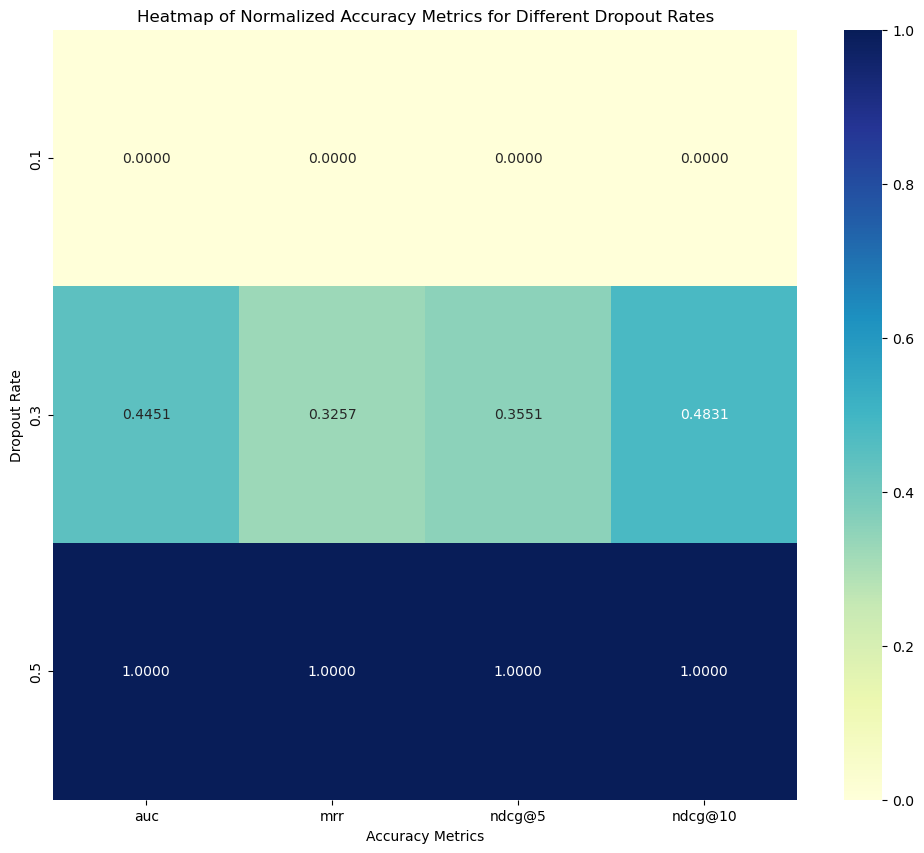

In [62]:
# Group by dropout and calculate the mean of each metric
mean_results = df.groupby('dropout').mean().reset_index()

# Select only the relevant columns for the heatmap
heatmap_data = mean_results[['dropout', 'auc', 'mrr', 'ndcg@5', 'ndcg@10']]

# Set the dropout column as the index
heatmap_data.set_index('dropout', inplace=True)

# Normalize each metric individually
scaler = MinMaxScaler()
heatmap_data[['auc', 'mrr', 'ndcg@5', 'ndcg@10']] = scaler.fit_transform(heatmap_data[['auc', 'mrr', 'ndcg@5', 'ndcg@10']])

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(heatmap_data, annot=True, fmt=".4f", cmap="YlGnBu", cbar=True)
plt.title('Heatmap of Normalized Accuracy Metrics for Different Dropout Rates')
plt.ylabel('Dropout Rate')
plt.xlabel('Accuracy Metrics')
plt.show()